In [1]:
from shapely.geometry import Point, Polygon
from shapely.plotting import patch_from_polygon
import matplotlib.pyplot as plt
import math 
import random
from src.core.polygon_utils import box_to_coords, sample_from_polygon, check_if_polygons_overlap, inflate_polygon

In [47]:
def add_random_table(room_coords, other_tables_coords, min_distance_between_tables, table_size=None, rotation_angle=None, max_iter = 50000):
    ''' 
    :param room_coords: list of tuples (x,y) shape:(4,2) representing the coordinates of the room
    :param table_size: string representing the size of the table or two numbers representing width and length of the table
    :return: list of tuples (x,y) shape:(4,2) representing the coordinates of the table
    '''
    # handle parameter table_size
    i = 0
    while True and i < max_iter:
        i += 1
        table_coords = generate_random_table_coords(room_coords, table_size, rotation_angle)
        if check_if_table_is_valid(room_coords, table_coords, other_tables_coords, min_distance_between_tables): 
            return table_coords


def generate_random_table_coords(room_coords, table_size = None, rotation_angle = None):
    # 1. Handle input
    if table_size == None: table_size = (random.randint(5,10), random.randint(1,3))
    elif table_size == 'small': table_size = (1,2)
    elif table_size == 'medium': table_size = (1,3)
    elif table_size == 'large': table_size = (2,4)
    elif isinstance (table_size, (tuple, list)) and len(table_size) == 2: pass
    else : raise ValueError('table_size must be "small", "medium", "large" or a tuple of two numbers')

    if rotation_angle == None: rotation_angle = random.randint(0,360)
    elif isinstance(rotation_angle, (float, int)): pass
    else : raise ValueError('rotation_angle must be an integer')
    rotation_angle = math.radians(rotation_angle) # transfer to radians

    # 2. Generate random origin point
    origin_coords = sample_from_polygon(room_coords)
    # 3. generate random coordinates for the table
    table_coords = box_to_coords(table_size, origin_coords, rotation_angle)
    return table_coords


def check_if_table_is_valid(room_coords, table_coords, other_tables_coords, min_distance_between_tables):
    # check if the table is inside the room
    if not Polygon(room_coords).contains(Polygon(table_coords)): return False
    # check if table is not overlapping (or too close) to other tables
    for other_table_coords in other_tables_coords:
        if check_if_polygons_overlap(Polygon(table_coords), Polygon(other_table_coords)): return False # this line probs unnecessary
        if check_if_polygons_overlap(inflate_polygon(Polygon(table_coords), min_distance_between_tables), Polygon(other_table_coords)): return False
    return True


def plot(tables_coord,room_coord):
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    patch = patch_from_polygon(Polygon(room_coord), facecolor=[0,0,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
    ax.add_patch(patch)
    for table_coord in tables_coord:
        patch = patch_from_polygon(Polygon(table_coord), facecolor=[0,1,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
        ax.add_patch(patch)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    plt.show()



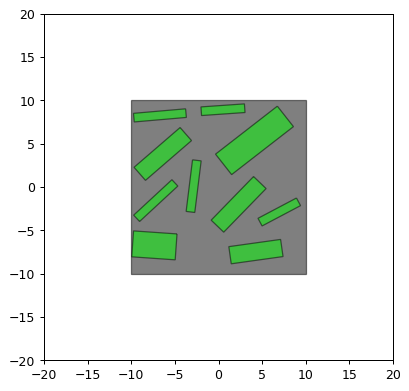

In [50]:
room_coords = [(-10, -10), (-10, 10), (10, 10), (10, -10)]
tables = []
for i in range(10):
    table_coords = add_random_table(room_coords, tables, 1)
    tables.append(table_coords)
plot(tables,room_coords)